In [2]:
# Force Jupyter to update loaded modules as they change
%load_ext autoreload
%autoreload 2
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
!pip install pytorch-lightning==1.3.7 > /dev/null
!pip install numpy==1.20.2
!pip install tensorboard
!pip install scikit-learn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

path_to_project_dir = Path("/content/drive/MyDrive/protein_prediction")
data_path = Path("./data")
emb_path = Path("./MSA1_embeddings_disorder.h5")
methods_code_path = Path("./methods")

if not path_to_project_dir.exists():
  !mkdir /content/drive/MyDrive/protein_prediction

  # download the baseline data
  if not data_path.exists():
      !wget www.rostlab.org/~bindpredict/datasets_pp1cb/disorder.zip
      !unzip disorder.zip

  # download the emebeddings
  if not emb_path.exists():
    !wget www.rostlab.org/~ss_msa_avg/datasets_pp1cb/MSA_embeddings_disorder.zip
    !unzip MSA_embeddings_disorder.zip

  if not methods_code_path.exists():  
  # clone the git directory and restructure the code BMRB
    !git clone https://github.com/stelviopas/pp1cb_ss21.git
    !mv pp1cb_ss21/methods .
    !mv pp1cb_ss21/visualization .

    #clean up a little bit
    !rm *.zip
    !rm -R pp1cb_ss21
    
    

    !mv methods /content/drive/MyDrive/protein_prediction
    !mv data /content/drive/MyDrive/protein_prediction
    !mv visualization /content/drive/MyDrive/protein_prediction
    !mv *.h5 /content/drive/MyDrive/protein_prediction

#change to our main working directory 
%cd /content/drive/MyDrive/protein_prediction
#display the folder structure 
!ls

Mounted at /content/drive
/content/drive/MyDrive/protein_prediction
data		MSA1_embeddings_disorder.h5  predict_disorder.ipynb
lightning_logs	MSA2_embeddings_disorder.h5  visualization
methods		MSA3_embeddings_disorder.h5


In [7]:
import methods.nn.disorder_dataset as dd 
from methods.utils.read_embeddings import read_embeddings, read_z_scores
from methods.utils.readfasta import readfasta

embeddings = read_embeddings("./data/baseline_embeddings_disorder.h5")
z_scores = read_z_scores('./data/disorder_labels.fasta')

disorder_labels = readfasta('./data/disorder_seq.fasta','./data/disorder_labels.fasta')

print('Proteins in the data set: ')
for key,val in disorder_labels.items():
  print(key)


Reading embeddings...done! Found 1102 proteins.
Reading Z-scores...done! Found 1102 proteins.
Read Done With 1102 Reads and 1102 Labels
Proteins in the data set: 
16364
19550
11245
5950
15811
6980
11162
18201
15482
25773
11423
15279
15584
10292
5335
19752
10136
16214
11355
16779
15940
17899
15109
19426
18672
18551
25543
15654
18214
11017
15324
11491
17628
17286
15790
6300
6926
19312
16895
7079
6780
17199
7023
11132
17075
15440
11038
17673
4046
10041
7225
6747
4860
10056
11275
25706
25762
6743
11093
18990
5624
5075
19491
10246
16424
18428
4915
17962
10320
4766
18288
4621
6372
15807
19299
10244
15693
17021
15789
17023
19436
11314
16638
15158
19023
25002
11009
25346
4871
17867
18615
18255
16998
19966
15660
6419
4328
16490
6864
15609
4255
7226
17112
5603
17050
18484
11201
19380
17971
16839
15449
17038
17554
18812
6000
11549
6570
18557
11041
10286
15528
25350
15834
16249
11321
5849
16031
5661
18211
11281
5691
6899
17345
17233
15448
25402
18355
11257
15677
25498
18765
17318
18380
16258
10038

# Ground truth

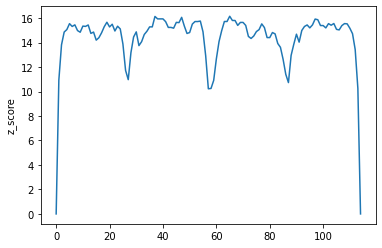

In [8]:
import seaborn as sns
import pandas as pd
from methods.nn.disorder_dataset import interpolate_values_in_list

test_id = '7247'
test_z_score = list(z_scores[test_id])
test_z_score = interpolate_values_in_list(test_z_score, padding_interpolation=True)



def plot_z_score_profile(z_score):
  df = pd.DataFrame(z_score, columns=["z_score"])
  sns.lineplot(data=df, x=df.index, y=df.z_score)

def plot_pred_vs_exp(pred, exp, unit="z_score"):
  values = [*pred, *exp]
  labels = [*[unit + '_pred' for p in pred], *[unit + '_exp' for e in exp]]
  df = pd.DataFrame(list(zip(values,labels)), columns=['values', 'labels'])
  print(df)
  sns.lineplot(data=df)


plot_z_score_profile(test_z_score)

# Prediction

In [9]:
from methods.nn.disorder_dataset import load_protein
import pytorch_lightning as pl
import torch
from methods.nn.ffnet import FFNet
from pytorch_lightning.callbacks import ModelCheckpoint

hparams = {'batch_size': 1, 'hidden_size': 128, 'learning_rate': 0.001, 'window_size': 35}

# load a single protein to the dataset object 
test_embedding = [embeddings[test_id]]

one_protein_dataset = load_protein(test_embedding, [test_z_score], window_size=35)
one_protein_loader = torch.utils.data.DataLoader(one_protein_dataset,
                                                  batch_size=1)
model = FFNet(hparams=hparams)

# import the best trained model
# baseline + window_size = 35

#predict the z_values
best_model_path = './best_model/baseline_35/version_27/checkpoints/epoch=15.ckpt'

best_model = model.load_from_checkpoint(best_model_path, hparams=hparams)

trainer = pl.Trainer()  
trainer.test(best_model,test_dataloaders=one_protein_loader)
test_loss = model.test_results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


115
115
(1024, 35)
0.0
0.0
Samples per bin [  2   0   9 104]
Thresholds of bins [0.   0.25 0.5  0.75 1.  ]
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=35840, out_features=128, bias=True)
  (2): PReLU(num_parameters=1)
  (3): Linear(in_features=128, out_features=32, bias=True)
  (4): PReLU(num_parameters=1)
  (5): Linear(in_features=32, out_features=1, bias=True)
  (6): Sigmoid()
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=35840, out_features=128, bias=True)
  (2): PReLU(num_parameters=1)
  (3): Linear(in_features=128, out_features=32, bias=True)
  (4): PReLU(num_parameters=1)
  (5): Linear(in_features=32, out_features=1, bias=True)
  (6): Sigmoid()
)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


# Compare predicted z-scores vs expermiental estimates

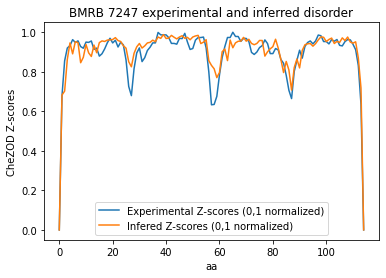

In [13]:
import matplotlib.pyplot as plt

test_prediction = torch.cat(best_model.prediction)
test_exp = torch.cat(best_model.exp)

# line 1 points
x = [i for i,_ in enumerate(test_prediction)]
y1 = test_exp
# plotting the line 1 points 
plt.plot(x, y1, label = "Experimental Z-scores (0,1 normalized)")
# line 2 points

y2 = test_prediction
# plotting the line 2 points 
plt.plot(x, y2, label = "Infered Z-scores (0,1 normalized)")
plt.xlabel('aa')
# Set the y axis label of the current axis.
plt.ylabel('CheZOD Z-scores')
# Set a title of the current axes.
plt.title(f"BMRB {test_id} experimental and inferred disorder")
# show a legend on the plot
plt.legend()
# Display a figure.
#plt.show()
plt.savefig(f"./visualization/prediction_{test_id}.png")

In [ ]:
# TO DO : fix the seaborn plot 


def plot_pred_vs_exp(pred, exp, unit="z_score"):
  values = [*pred, *exp]
  labels = [*[unit + '_pred' for p in pred], *[unit + '_exp' for e in exp]]
  df = pd.DataFrame(list(zip(values,labels)), columns=['values', 'labels'])
  print(df)
  sns.lineplot(data=df, x=df.index, y=df["values"])